# This is my Practicum I Project on predicting lung disease
## I will Build a CNN using transfer learning and data augmentation. The data images have already been split into training, validataion, and test sets and loaded to  my Google Drive for access.

## MSDS 692 Practicum I Project
## Odes Mullins

In [0]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [0]:
from keras import backend as K
from keras import backend
from keras import models
from keras import layers
from keras import optimizers
from keras import regularizers
from keras.utils import to_categorical
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from IPython.display import display # Library to help view images
from PIL import Image # Library to help view images
from keras.preprocessing.image import ImageDataGenerator # Library for data augmentation
from keras.preprocessing import image
import os, shutil # Library for navigating files
from google.colab import drive # Library to mount google drives
np.random.seed(42)

Using TensorFlow backend.


### We need to mount the google drive to access the images. Paste the authorization code into your browser

In [0]:

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# Specify the base directory where images are located.
base_dir = '/content/gdrive/My Drive/NihChestXray'

In [0]:
# Specify the traning, validation, and test dirrectories.  
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

In [0]:
# Specify the classess in the training, validataion, and test dirrectories
train_emph_dir = os.path.join(train_dir, 'emph')
train_fibr_dir = os.path.join(train_dir, 'fibr')
train_hern_dir = os.path.join(train_dir, 'hern')
train_mass_dir = os.path.join(train_dir, 'mass')
train_nf_dir = os.path.join(train_dir, 'nf')
train_pneu_dir = os.path.join(train_dir, 'pneu')

validation_emph_dir = os.path.join(validation_dir, 'emph')
validation_fibr_dir = os.path.join(validation_dir, 'fibr')
validation_hern_dir = os.path.join(validation_dir, 'hern')
validation_mass_dir = os.path.join(validation_dir, 'mass')
validation_nf_dir = os.path.join(validation_dir, 'nf')
validation_pneu_dir = os.path.join(validation_dir, 'pneu')

test_emph_dir = os.path.join(test_dir, 'emph')
test_fibr_dir = os.path.join(test_dir, 'fibr')
test_hern_dir = os.path.join(test_dir, 'hern')
test_mass_dir = os.path.join(test_dir, 'mass')
test_nf_dir = os.path.join(test_dir, 'nf')
test_pneu_dir = os.path.join(test_dir, 'pneu')


In [0]:
# Check the number of files in each class dirrectory
print(len(os.listdir(train_emph_dir)))
print(len(os.listdir(train_fibr_dir)))
print(len(os.listdir(train_hern_dir)))
print(len(os.listdir(train_mass_dir)))
print(len(os.listdir(train_nf_dir)))
print(len(os.listdir(train_pneu_dir)))
print(len(os.listdir(validation_emph_dir)))
print(len(os.listdir(validation_fibr_dir)))
print(len(os.listdir(validation_hern_dir)))
print(len(os.listdir(validation_mass_dir)))
print(len(os.listdir(validation_nf_dir)))
print(len(os.listdir(validation_pneu_dir)))
print(len(os.listdir(test_emph_dir)))
print(len(os.listdir(test_fibr_dir)))
print(len(os.listdir(test_hern_dir)))
print(len(os.listdir(test_mass_dir)))
print(len(os.listdir(test_nf_dir)))
print(len(os.listdir(test_pneu_dir)))

602
507
81
1356
140
214
170
141
20
386
39
56
67
47
8
161
23
37


In [0]:
# We need to normalize the pixels in the images.  The data will 'flow' through this generator.
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [0]:
# Since the file images are in a directory we need to move them from the directory into the model.  
# Keras as a function that makes this easy. Documentaion is here: https://keras.io/preprocessing/image/

train_generator = train_datagen.flow_from_directory(
    train_dir, # The directory where the train data is located
    target_size=(150, 150), # Reshape the image to 150 by 150 pixels. This is important because it makes sure all images are the same size.
    batch_size=20, # We will take images in batches of 20.
    class_mode='categorical') # The classification is categorical.

validataion_generator = train_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical')

Found 2900 images belonging to 6 classes.
Found 812 images belonging to 6 classes.
Found 343 images belonging to 6 classes.


### The following steps read the csv file and performs Exploratory Data Analysis (EDA) on the file. I focused on the Patient Age and Patient Gender as they are areas of interest to see how the images are distributed.


In [0]:
# Perform EDA on csv file for all images used for this project

nih_extract_df = pd.read_csv(os.path.join(base_dir, 'Data_Entry_2017_Reduce.csv'))

nih_extract_df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4055 entries, 0 to 4054
Data columns (total 11 columns):
Image Index                    4055 non-null object
Finding Labels                 4055 non-null object
Follow-up #                    4055 non-null int64
Patient ID                     4055 non-null int64
Patient Age                    4055 non-null int64
Patient Gender                 4055 non-null object
View Position                  4055 non-null object
OriginalImage[Width            4055 non-null int64
Height]                        4055 non-null int64
OriginalImagePixelSpacing[x    4055 non-null float64
y]                             4055 non-null float64
dtypes: float64(2), int64(5), object(4)
memory usage: 348.6+ KB


In [0]:
# Check for missing values

nih_extract_df.isnull().sum()



Image Index                    0
Finding Labels                 0
Follow-up #                    0
Patient ID                     0
Patient Age                    0
Patient Gender                 0
View Position                  0
OriginalImage[Width            0
Height]                        0
OriginalImagePixelSpacing[x    0
y]                             0
dtype: int64

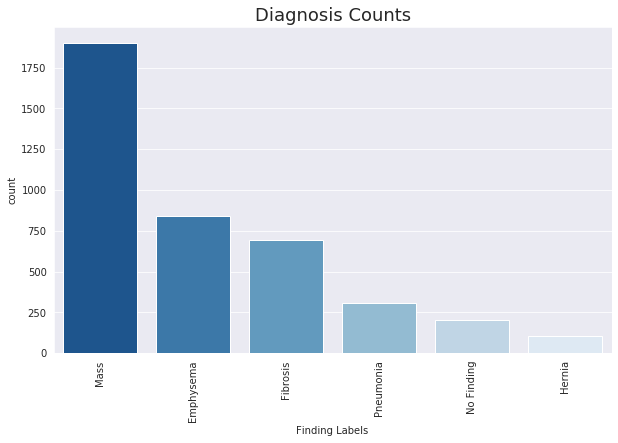

Mass          1903
Emphysema      839
Fibrosis       695
Pneumonia      307
No Finding     202
Hernia         109
Name: Finding Labels, dtype: int64


In [0]:
# Plot the diagnosis counts for each of the 6 categories

sns.set_style("darkgrid")
plt.figure(figsize=(10, 6))
sns.countplot(x = nih_extract_df['Finding Labels'], #fFinding Labels
                     order = nih_extract_df['Finding Labels'].value_counts().index, #Finding Labels
                     palette= "Blues_r")
plt.xticks(rotation = 90) 
plt.title('Diagnosis Counts',fontsize=18) 
plt.show()
print(nih_extract_df['Finding Labels'].value_counts())



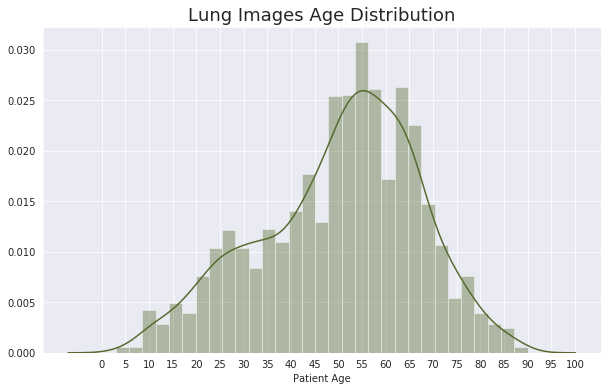

In [0]:
# Plot the distribution of the lung x-ray images age distribution

sns.set_style("darkgrid")
plt.figure(figsize=(10,6))
plt.title('Lung Images Age Distribution',fontsize=18)
sns.distplot(nih_extract_df['Patient Age'], color= 'darkolivegreen')
plt.xticks(list(range(0,105,5)))

plt.show()



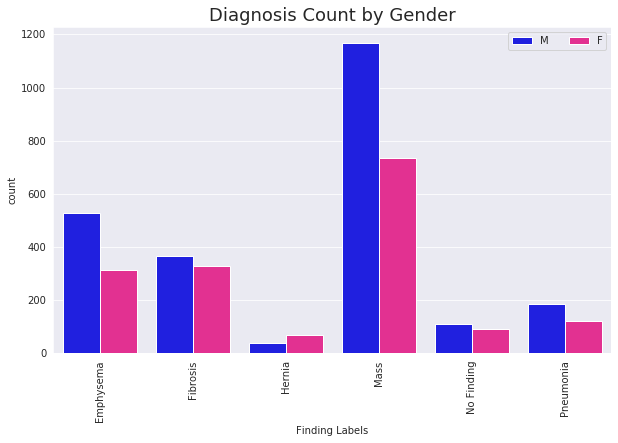

In [0]:
# Plot diagnosis count by gender

sns.set_style("darkgrid")
plt.figure(figsize=(10, 6))
sns.countplot(x='Finding Labels',  
              hue='Patient Gender', 
              palette=['blue',  'deeppink'],
              data=nih_extract_df)
plt.legend(loc='upper right', ncol =2)  
plt.xticks(rotation = 90) 
plt.title('Diagnosis Count by Gender',fontsize=18)
plt.show()



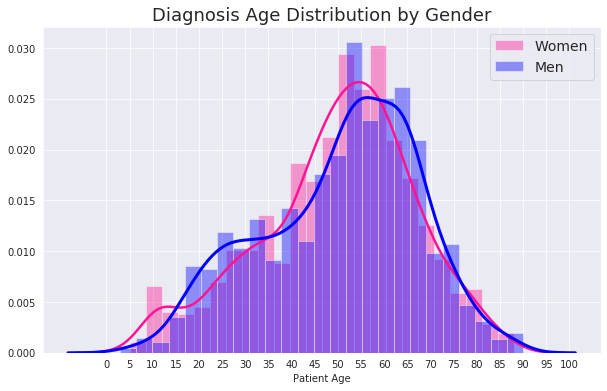

In [0]:
# Plot diagnosis age distribution by gender

sns.set_style("darkgrid")
plt.figure(figsize=(10, 6))
sns.distplot(nih_extract_df[nih_extract_df['Patient Gender']=='F']['Patient Age'], 
             label='Women', 
             color="deeppink",
             kde_kws=dict(linewidth=2.5))
sns.distplot(nih_extract_df[nih_extract_df['Patient Gender']=='M']['Patient Age'], 
             label='Men', 
             color="blue",
             kde_kws=dict(linewidth=3))

plt.title('Diagnosis Age Distribution by Gender',fontsize=18)
plt.xticks(list(range(0,105,5)))
plt.legend(loc='upper right', fontsize='14')
plt.show()



In [0]:
# Print the distribution of the x-ray images by gender

print(nih_extract_df.groupby('Patient Gender')['Patient Age'].count())



Patient Gender
F    1659
M    2396
Name: Patient Age, dtype: int64


Epoch 1/50
100/100 [==============================] - 63s 633ms/step - loss: 2.4919 - acc: 0.3210 - val_loss: 4.5262 - val_acc: 0.2413
Epoch 2/50
100/100 [==============================] - 61s 608ms/step - loss: 1.9903 - acc: 0.3945 - val_loss: 3.1517 - val_acc: 0.3283
Epoch 3/50
100/100 [==============================] - 60s 599ms/step - loss: 1.7924 - acc: 0.4505 - val_loss: 2.3791 - val_acc: 0.1250
Epoch 4/50
100/100 [==============================] - 61s 607ms/step - loss: 1.6986 - acc: 0.4645 - val_loss: 5.4427 - val_acc: 0.4356
Epoch 5/50
100/100 [==============================] - 59s 590ms/step - loss: 1.6820 - acc: 0.4545 - val_loss: 6.5751 - val_acc: 0.4255
Epoch 6/50
100/100 [==============================] - 59s 591ms/step - loss: 1.5642 - acc: 0.4790 - val_loss: 1.8274 - val_acc: 0.4747
Epoch 7/50
100/100 [==============================] - 59s 594ms/step - loss: 1.6001 - acc: 0.4565 - val_loss: 6.4928 - val_acc: 0.4672
Epoch 8/50
100/100 [==============================] - 5

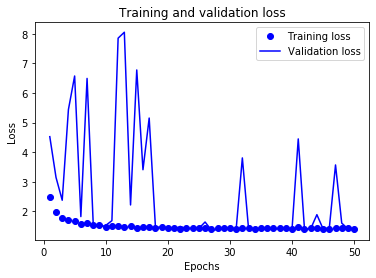

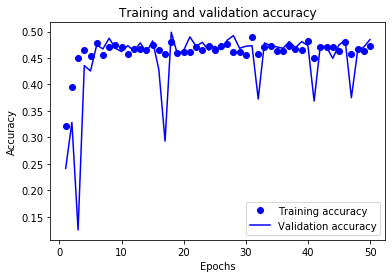

test_acc: 0.4679089023212962


In [0]:
# Now we build model 1.

backend.clear_session()
model = models.Sequential()

model.add(layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (150, 150, 3)))
model.add(layers.MaxPool2D((2,2)))
model.add(BatchNormalization())

model.add(layers.Conv2D(32, (3,3), activation = 'relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(BatchNormalization())

model.add(layers.Conv2D(32, (3,3), activation = 'relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(BatchNormalization())

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(6, activation='softmax'))

model.compile(optimizer = 'rmsprop',
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])

history = model.fit_generator( # The image data must come from the image generator that takes the images from the correct directory. https://keras.io/models/sequential/
    train_generator, # Images are taken from the train_generator
    steps_per_epoch=100, # The number of steps from the train_generator before one epoch if finished.  
                         # 100 steps * 20 batch size in train generator = 2000 training images per epoch. This way each traning image will be sampled once per epoch.
    epochs=50, # Train data for 29 epochs
    validation_data=validataion_generator, # Take data from the validataion generator
    validation_steps=40, # 40 steps * 20 batch size in validation generator = 800 validation images per epoch
    verbose = 1) # We will not use call backs to stop early.

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(history_dict['acc']) + 1)

plt.plot(epochs, loss_values, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss_values, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, acc_values, 'bo', label = 'Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

test_loss, test_acc = model.evaluate_generator(test_generator, steps = 25) # Test images are in a directory so they must flow from directory. 
                                                                           # 25 steps * 20 batch size in test generator = 500 test images per epoch
print('test_acc:', test_acc)

model.save('Practicum_Nih_Pred_Lung_disease_1.h5')

### The above model came out just under 47% accuracy which is not that good but I believe that is due to overfitting. I will try 20 epochs to see if I can resolve the overfitting and make additional adjustments due to low amount of data in some categories.


Epoch 1/20
100/100 [==============================] - 64s 644ms/step - loss: 2.6413 - acc: 0.3510 - val_loss: 5.1587 - val_acc: 0.4763
Epoch 2/20
100/100 [==============================] - 61s 609ms/step - loss: 1.9033 - acc: 0.3970 - val_loss: 7.6287 - val_acc: 0.4798
Epoch 3/20
100/100 [==============================] - 60s 603ms/step - loss: 1.7808 - acc: 0.4345 - val_loss: 1.6478 - val_acc: 0.4407
Epoch 4/20
100/100 [==============================] - 60s 599ms/step - loss: 1.6430 - acc: 0.4575 - val_loss: 2.8092 - val_acc: 0.3295
Epoch 5/20
100/100 [==============================] - 60s 595ms/step - loss: 1.5724 - acc: 0.4550 - val_loss: 1.4923 - val_acc: 0.4697
Epoch 6/20
100/100 [==============================] - 60s 603ms/step - loss: 1.5698 - acc: 0.4540 - val_loss: 8.5475 - val_acc: 0.4697
Epoch 7/20
100/100 [==============================] - 59s 593ms/step - loss: 1.5333 - acc: 0.4625 - val_loss: 2.0559 - val_acc: 0.4318
Epoch 8/20
100/100 [==============================] - 5

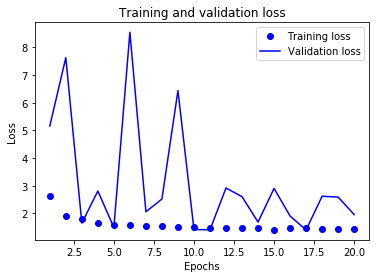

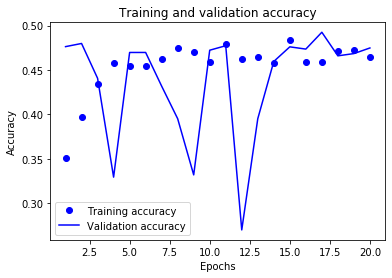

test_acc: 0.46169772503538903


In [0]:
# Now we build model 2.

backend.clear_session()
model = models.Sequential()

model.add(layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (150, 150, 3)))
model.add(layers.MaxPool2D((2,2)))
model.add(BatchNormalization())

model.add(layers.Conv2D(32, (3,3), activation = 'relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(BatchNormalization())

model.add(layers.Conv2D(32, (3,3), activation = 'relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(BatchNormalization())

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(6, activation='softmax'))

model.compile(optimizer = 'rmsprop',
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])

history = model.fit_generator( # The image data must come from the image generator that takes the images from the correct directory. https://keras.io/models/sequential/
    train_generator, # Images are taken from the train_generator
    steps_per_epoch=100, # The number of steps from the train_generator before one epoch if finished.  
                         # 100 steps * 20 batch size in train generator = 2000 training images per epoch. This way each traning image will be sampled once per epoch.
    epochs=20, # Train data for 15 epochs
    validation_data=validataion_generator, # Take data from the validataion generator
    validation_steps=40, # 40 steps * 20 batch size in validation generator = 800 validation images per epoch
    verbose = 1) # We will not use call backs to stop early.

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(history_dict['acc']) + 1)

plt.plot(epochs, loss_values, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss_values, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, acc_values, 'bo', label = 'Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

test_loss, test_acc = model.evaluate_generator(test_generator, steps = 25) # Test images are in a dirrectory so they must flow from directory. 
                                                                           # 25 steps * 20 batch size in test generator = 500 test images per epoch
print('test_acc:', test_acc)

model.save('Practicum_Nih_Pred_Lung_disease_2.h5')

### The above model came out with about 47% accuracy which is a little better than model 1. Now lets try to improve using data augmentation.
#### Data augmentation allows us to randomally transform images before sending them to the model for training.  The random transformation changes the images into 'new' images and allows for an increase in traning data without have additional images. https://keras.io/preprocessing/image/ 

---



In [0]:
datagen = ImageDataGenerator( # The image augmentaion function in Keras
    rotation_range=40, # Rotate the images randomly by 40 degrees
    width_shift_range=0.2, # Shift the image horizontally by 20%
    height_shift_range=0.2, # Shift the image veritcally by 20%
    shear_range=0.2, # Shear image by 20%
    zoom_range=0.2, # Zoom in on image by 20%
    horizontal_flip=True, # Flip image horizontally 
    fill_mode='nearest') # How to fill missing pixels after a augmentaion opperation

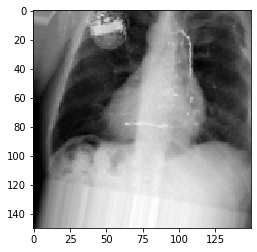

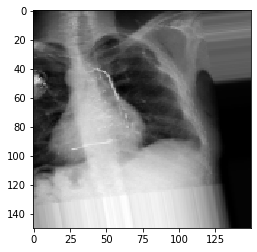

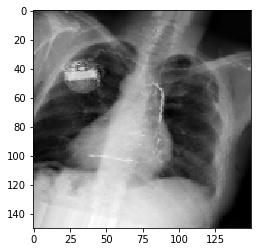

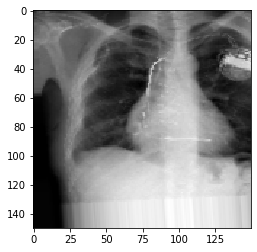

In [0]:
# Lets see the image augmentaion
from keras.preprocessing import image
img = image.load_img(os.path.join(train_emph_dir, os.listdir(train_emph_dir)[1]), target_size=(150,150))
x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)
i = 0 
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break
plt.show()

In [0]:
# Apply the data augmentation to our data.
train_datagen2 = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen2 = ImageDataGenerator(rescale=1./255) #Never apply data augmentation to test data.  You only want to normalize and resize test data. 

train_generator2 = train_datagen2.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical')

validataion_generator2 = train_datagen2.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical')

test_generator2 = test_datagen2.flow_from_directory( # Resize test data
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical')

Found 2900 images belonging to 6 classes.
Found 812 images belonging to 6 classes.
Found 343 images belonging to 6 classes.


Epoch 1/30
100/100 [==============================] - 96s 958ms/step - loss: 2.7168 - acc: 0.3482 - val_loss: 2.0204 - val_acc: 0.3722
Epoch 2/30
100/100 [==============================] - 87s 871ms/step - loss: 2.1159 - acc: 0.3684 - val_loss: 1.9064 - val_acc: 0.3944
Epoch 3/30
100/100 [==============================] - 87s 874ms/step - loss: 1.9001 - acc: 0.3942 - val_loss: 1.8151 - val_acc: 0.4206
Epoch 4/30
100/100 [==============================] - 88s 878ms/step - loss: 1.7712 - acc: 0.4171 - val_loss: 1.5379 - val_acc: 0.4395
Epoch 5/30
100/100 [==============================] - 88s 881ms/step - loss: 1.7599 - acc: 0.4047 - val_loss: 1.6364 - val_acc: 0.4246
Epoch 6/30
100/100 [==============================] - 90s 896ms/step - loss: 1.6305 - acc: 0.4224 - val_loss: 1.6589 - val_acc: 0.4484
Epoch 7/30
100/100 [==============================] - 87s 869ms/step - loss: 1.6036 - acc: 0.4377 - val_loss: 1.7846 - val_acc: 0.4667
Epoch 8/30
100/100 [==============================] - 8

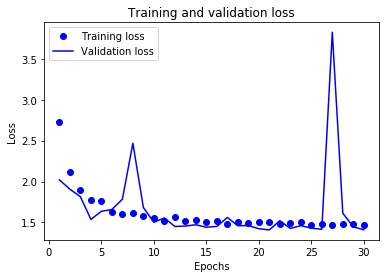

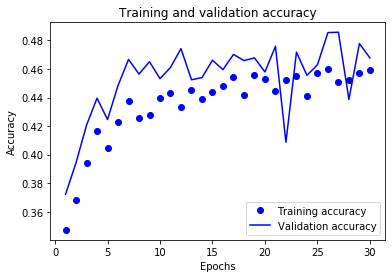

test_acc: 0.46790890195108104


In [0]:
# Now we build model 3.

backend.clear_session()
model = models.Sequential()

model.add(layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (150, 150, 3)))
model.add(layers.MaxPool2D((2,2)))
model.add(BatchNormalization())
model.add(layers.Conv2D(64, (3,3), activation = 'relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(BatchNormalization())
model.add(layers.Conv2D(128, (3,3), activation = 'relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(BatchNormalization())
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(6, activation='softmax'))

model.compile(optimizer = optimizers.rmsprop(lr=0.0001), # We will lower learning rate
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])


history = model.fit_generator(
    train_generator2,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validataion_generator2,
    validation_steps=40,
    verbose = 1)


history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(history_dict['acc']) + 1)

plt.plot(epochs, loss_values, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss_values, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, acc_values, 'bo', label = 'Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

test_loss, test_acc = model.evaluate_generator(test_generator2, steps = 25)
print('test_acc:', test_acc)

model.save('Practicum_Nih_Pred_Lung_disease_3.h5')

## Having more data should help with the accuracy but I don't see any improvement. 
### But lets use the InceptionV3 pre-trained model to see if there is an improvement.  https://keras.io/applications/

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 74, 74, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 74, 74, 32)   0           batch_normalization_1[0][0]      
_______________________________________________________________________________________

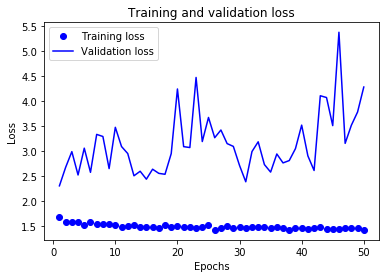

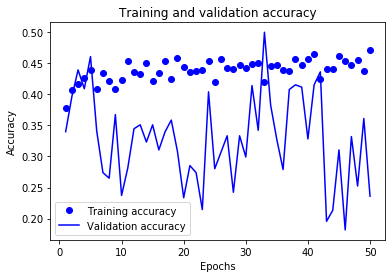

test_acc: 0.161490686870263


In [0]:
# Now we build model 4.

from keras.applications import InceptionV3 # Import the InceptionV3 library. 

backend.clear_session()
conv_base = InceptionV3 (weights = 'imagenet', #Useing the VGG66 CNN that was trained on ImageNet data.  
                         include_top = False, # We are using our own classification (dog or cat) and not the ImageNet multiclassification. So include top = false.
                         input_shape = (150, 150, 3))

conv_base.summary() # View the InceptionV3 model architecture.

conv_base.trainable = False # Freeze the InceptionV3 weights.

conv_base.summary() # Lets look at the parameters now.

modelv3 = models.Sequential()
modelv3.add(conv_base) # Add the InceptionV3 weights
modelv3.add(layers.Flatten())
modelv3.add(layers.Dense(6, activation = 'softmax'))

# We will use data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical')

validataion_generator = train_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical')

modelv3.compile(optimizer = optimizers.rmsprop(lr=0.0001),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'])

history = modelv3.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=50,
    validation_data=validataion_generator,
    validation_steps=40)

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(history_dict['acc']) + 1)

plt.plot(epochs, loss_values, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss_values, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, acc_values, 'bo', label = 'Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

test_loss, test_acc = modelv3.evaluate_generator(test_generator, steps = 25)
print('test_acc:', test_acc)

modelv3.save('Practicum_Nih_Pred_Lung_disease_4.h5')

<keras.engine.input_layer.InputLayer object at 0x7fb817fda780> False
<keras.layers.convolutional.Conv2D object at 0x7fb817fdaef0> False
<keras.layers.normalization.BatchNormalization object at 0x7fb817fda320> False
<keras.layers.core.Activation object at 0x7fb817fda470> False
<keras.layers.convolutional.Conv2D object at 0x7fb817fda358> False
<keras.layers.normalization.BatchNormalization object at 0x7fb817f2ea58> False
<keras.layers.core.Activation object at 0x7fb817f2e9e8> False
<keras.layers.convolutional.Conv2D object at 0x7fb817f26f60> False
<keras.layers.normalization.BatchNormalization object at 0x7fb817e6e198> False
<keras.layers.core.Activation object at 0x7fb817e6ef60> False
<keras.layers.pooling.MaxPooling2D object at 0x7fb817e8db00> False
<keras.layers.convolutional.Conv2D object at 0x7fb817e61f98> False
<keras.layers.normalization.BatchNormalization object at 0x7fb817eed710> False
<keras.layers.core.Activation object at 0x7fb817eede10> False
<keras.layers.convolutional.Conv

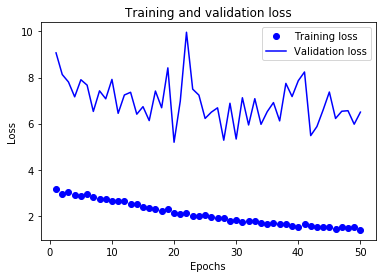

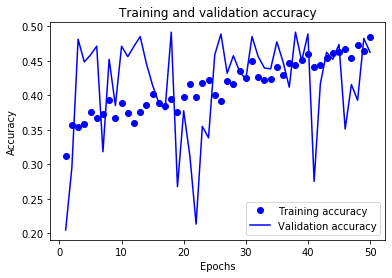

test_acc: 0.4575569338433244


In [0]:
# Now we build model 5.

backend.clear_session()
v3_base_2 = InceptionV3(weights = 'imagenet', include_top = False, input_shape = (150, 150, 3))

# Here we freeze all the layers except the last 20.
for layer in v3_base_2.layers[:-20]:
  layer.trainable = False
for layer in v3_base_2.layers:
  print(layer, layer.trainable)

v3_base_2.summary()

modelv3 = models.Sequential()
modelv3.add(v3_base_2) # Add the InceptionV3 weights
modelv3.add(layers.Flatten())
modelv3.add(layers.BatchNormalization())

modelv3.add(layers.Dense(1024, activation = 'relu'))
modelv3.add(layers.Dense(6, activation = 'softmax'))

# We will use data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical')

validataion_generator = train_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical')

modelv3.compile(optimizer = optimizers.rmsprop(lr=0.0001),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'])

history = modelv3.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=50,
    validation_data=validataion_generator,
    validation_steps=40)

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(history_dict['acc']) + 1)

plt.plot(epochs, loss_values, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss_values, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, acc_values, 'bo', label = 'Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

test_loss, test_acc = modelv3.evaluate_generator(test_generator, steps = 25)
print('test_acc:', test_acc)

modelv3.save('Practicum_Nih_Pred_Lung_disease_5.h5')

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 74, 74, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 74, 74, 32)   0           batch_normalization_1[0][0]      
_______________________________________________________________________________________

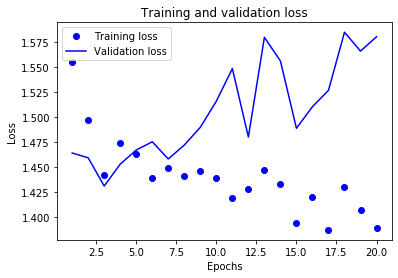

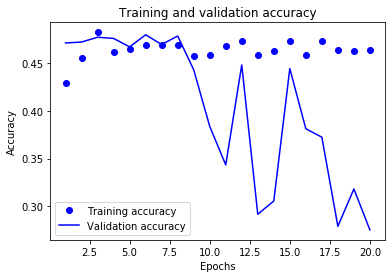

test_acc: 0.3167701884332898


In [0]:
# Now we build model 6.

from keras.applications import InceptionV3 # Import the InceptionV3 library. 

backend.clear_session()
v3_base_2 = InceptionV3(weights = 'imagenet', include_top = False, input_shape = (150, 150, 3))

v3_base_2.summary() # View the InceptionV3 model architecture.

v3_base_2.trainable = False # Freeze the InceptionV3 weights.

v3_base_2.summary() # Lets look at the parameters now.

weight_decay = 1e-4

modelv3 = models.Sequential()
modelv3.add(v3_base_2) # Add the InceptionV3 weights
modelv3.add(layers.SeparableConv2D(32, (3,3), padding = 'same', activation = 'relu', kernel_regularizer=regularizers.l2(weight_decay)))
modelv3.add(layers.SeparableConv2D(64, (3,3), padding = 'same', activation = 'relu', kernel_regularizer=regularizers.l2(weight_decay)))
modelv3.add(BatchNormalization())
modelv3.add(layers.Flatten())
modelv3.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
modelv3.add(layers.Dropout(0.5))

modelv3.add(layers.Dense(6, activation = 'softmax'))

# We will use data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical')

validataion_generator = train_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical')

modelv3.compile(optimizer = optimizers.rmsprop(lr=0.0001),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'])

history = modelv3.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=20,
    validation_data=validataion_generator,
    validation_steps=40)

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(history_dict['acc']) + 1)

plt.plot(epochs, loss_values, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss_values, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, acc_values, 'bo', label = 'Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

test_loss, test_acc = modelv3.evaluate_generator(test_generator, steps = 25)
print('test_acc:', test_acc)

modelv3.save('Practicum_Nih_Pred_Lung_disease_6.h5')

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 74, 74, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 74, 74, 32)   0           batch_normalization_1[0][0]      
_______________________________________________________________________________________

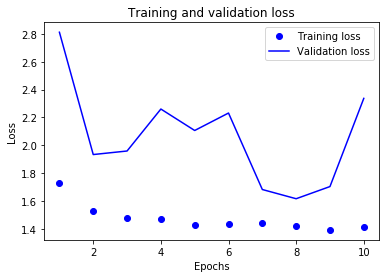

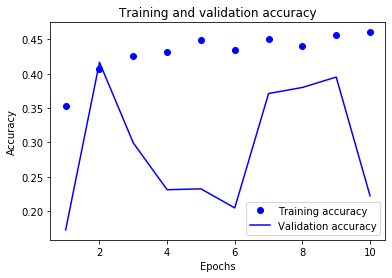

test_acc: 0.22153209288668188


In [0]:
# Now we build model 7.

from keras.applications import InceptionV3 # Import the InceptionV3 library. 

backend.clear_session()
v3_base_2 = InceptionV3(weights = 'imagenet', include_top = False, input_shape = (150, 150, 3))

v3_base_2.summary() # View the InceptionV3 model architecture.

v3_base_2.trainable = False # Freeze the InceptionV3 weights.

v3_base_2.summary()

modelv3 = models.Sequential()
modelv3.add(v3_base_2) # Add the InceptionV3 weights
modelv3.add(layers.Conv2D(128, (3,3), padding = 'same', activation = 'relu'))
modelv3.add(layers.Flatten())
modelv3.add(layers.BatchNormalization())

modelv3.add(layers.Dense(128, activation = 'relu'))
modelv3.add(layers.Dense(6, activation = 'softmax'))

# We will use data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical')

validataion_generator = train_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical')

modelv3.compile(optimizer = optimizers.rmsprop(lr=0.0001),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'])

history = modelv3.fit_generator(
    train_generator,
    steps_per_epoch=200,
    epochs=10,
    validation_data=validataion_generator,
    validation_steps=40)

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(history_dict['acc']) + 1)

plt.plot(epochs, loss_values, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss_values, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, acc_values, 'bo', label = 'Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

test_loss, test_acc = modelv3.evaluate_generator(test_generator, steps = 25)
print('test_acc:', test_acc)

modelv3.save('Practicum_Nih_Pred_Lung_disease_7.h5')

Epoch 1/20
100/100 [==============================] - 101s 1s/step - loss: 2.8888 - acc: 0.3236 - val_loss: 1.8489 - val_acc: 0.4167
Epoch 2/20
100/100 [==============================] - 92s 921ms/step - loss: 2.1494 - acc: 0.3741 - val_loss: 1.8538 - val_acc: 0.4355
Epoch 3/20
100/100 [==============================] - 92s 921ms/step - loss: 2.0235 - acc: 0.3821 - val_loss: 1.6651 - val_acc: 0.4413
Epoch 4/20
100/100 [==============================] - 92s 918ms/step - loss: 1.9015 - acc: 0.4056 - val_loss: 1.6664 - val_acc: 0.4274
Epoch 5/20
100/100 [==============================] - 93s 925ms/step - loss: 1.7829 - acc: 0.4158 - val_loss: 1.9400 - val_acc: 0.4437
Epoch 6/20
100/100 [==============================] - 94s 936ms/step - loss: 1.8035 - acc: 0.4122 - val_loss: 2.1543 - val_acc: 0.4629
Epoch 7/20
100/100 [==============================] - 93s 929ms/step - loss: 1.7782 - acc: 0.4045 - val_loss: 1.7044 - val_acc: 0.4651
Epoch 8/20
100/100 [==============================] - 93s

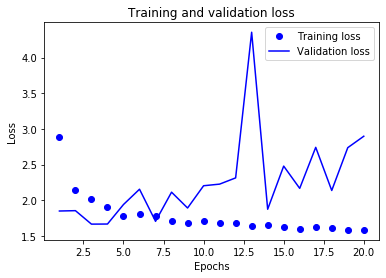

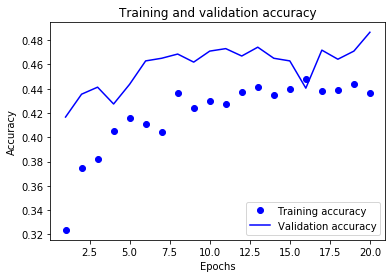

test_acc: 0.46790890583834044


In [0]:
# Now we build model 8.

backend.clear_session()
model = models.Sequential()

weight_decay = 1e-4

model.add(layers.Conv2D(32, (3,3), activation = 'relu', kernel_regularizer=regularizers.l2(weight_decay), input_shape = (150, 150, 3)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.1))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation = 'relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(layers.MaxPool2D((2,2)))
model.add(BatchNormalization())
model.add(layers.Conv2D(128, (3,3), activation = 'relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(layers.MaxPool2D((2,2)))
model.add(BatchNormalization())
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(6, activation='softmax'))

model.compile(optimizer = optimizers.rmsprop(lr=0.0001), # We will lower learning rate
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])


history = model.fit_generator(
    train_generator2,
    steps_per_epoch=100,
    epochs=20,
    validation_data=validataion_generator2,
    validation_steps=40,
    verbose = 1)


history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(history_dict['acc']) + 1)

plt.plot(epochs, loss_values, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss_values, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, acc_values, 'bo', label = 'Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

test_loss, test_acc = model.evaluate_generator(test_generator2, steps = 25)
print('test_acc:', test_acc)

model.save('Practicum_Nih_Pred_Lung_disease_8.h5')

<keras.engine.input_layer.InputLayer object at 0x7f7c1d887a58> False
<keras.layers.convolutional.Conv2D object at 0x7f7c1e1f5550> False
<keras.layers.convolutional.Conv2D object at 0x7f7c1e2095f8> False
<keras.layers.pooling.MaxPooling2D object at 0x7f7c1e229da0> False
<keras.layers.convolutional.Conv2D object at 0x7f7c1e1d4c88> False
<keras.layers.convolutional.Conv2D object at 0x7f7c1e1db4e0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f7c1e1d0240> False
<keras.layers.convolutional.Conv2D object at 0x7f7c1e1d6780> False
<keras.layers.convolutional.Conv2D object at 0x7f7c1e1cda58> False
<keras.layers.convolutional.Conv2D object at 0x7f7c1e1639b0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f7c1e16e160> False
<keras.layers.convolutional.Conv2D object at 0x7f7c1e16d898> False
<keras.layers.convolutional.Conv2D object at 0x7f7c1e17b9b0> False
<keras.layers.convolutional.Conv2D object at 0x7f7c1e181710> False
<keras.layers.pooling.MaxPooling2D object at 0x7f7c1e18f198>

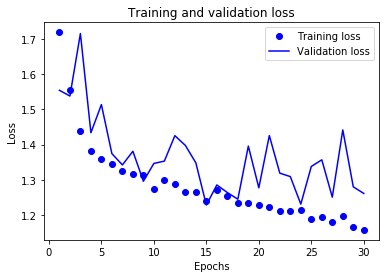

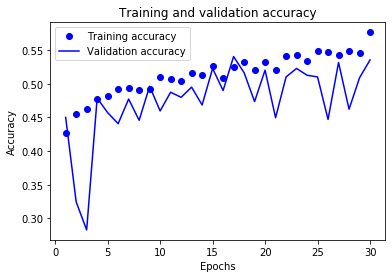

test_acc: 0.5320910953957102


In [0]:
# Now we build model 9.

from keras.applications import VGG16 # Import the VGG16 library.

backend.clear_session()
conv_base = VGG16 (weights = 'imagenet', #Useing the VGG66 CNN that was trained on ImageNet data.  
                  include_top = False, # We are using our own classification (lungs x-ray classification) and not the ImageNet multiclassification. So include top = false.
                  input_shape = (150, 150, 3))

# Here we freeze all the layers except the last 4.
for layer in conv_base.layers[:-4]:
  layer.trainable = False
for layer in conv_base.layers:
  print(layer, layer.trainable)

conv_base.summary() # Lets look at the parameters now.
weight_decay = 1e-4

modelvgg16 = models.Sequential()
modelvgg16.add(conv_base) # Add the InceptionV3 weights
modelvgg16.add(layers.SeparableConv2D(32, (3,3), padding = 'same', activation = 'elu', kernel_regularizer=regularizers.l2(weight_decay)))
modelvgg16.add(layers.SeparableConv2D(32, (3,3), padding = 'same', activation = 'elu', kernel_regularizer=regularizers.l2(weight_decay)))
modelvgg16.add(BatchNormalization())
modelvgg16.add(layers.Dropout(0.1))
modelvgg16.add(layers.MaxPool2D((2,2), padding = 'same'))
modelvgg16.add(layers.SeparableConv2D(64, (3,3), padding = 'same', activation = 'elu', kernel_regularizer=regularizers.l2(weight_decay)))
modelvgg16.add(layers.SeparableConv2D(64, (3,3), padding = 'same', activation = 'elu', kernel_regularizer=regularizers.l2(weight_decay)))
modelvgg16.add(layers.MaxPool2D((2,2), padding = 'same'))
modelvgg16.add(BatchNormalization())
modelvgg16.add(layers.SeparableConv2D(64, (3,3), padding = 'same', activation = 'elu', kernel_regularizer=regularizers.l2(weight_decay)))
modelvgg16.add(layers.SeparableConv2D(64, (3,3), padding = 'same', activation = 'elu', kernel_regularizer=regularizers.l2(weight_decay)))
modelvgg16.add(layers.MaxPool2D((2,2), padding = 'same'))
modelvgg16.add(BatchNormalization())
modelvgg16.add(layers.Flatten())
modelvgg16.add(layers.Dense(512, activation='elu', kernel_regularizer=regularizers.l2(weight_decay)))
modelvgg16.add(layers.Dropout(0.4))
modelvgg16.add(layers.Dense(6, activation = 'softmax'))

# We will use data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical')

validataion_generator = train_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical')

modelvgg16.compile(optimizer = optimizers.rmsprop(lr=0.0001),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'])

history = modelvgg16.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validataion_generator,
    validation_steps=40)

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(history_dict['acc']) + 1)

plt.plot(epochs, loss_values, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss_values, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, acc_values, 'bo', label = 'Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

test_loss, test_acc = modelvgg16.evaluate_generator(test_generator, steps = 25)
print('test_acc:', test_acc)

modelvgg16.save('Practicum_Nih_Pred_Lung_disease_9.h5')

In [0]:
backend.clear_session()
from keras.applications import VGG19 # Import the VGG19 library. 
conv_base = VGG19 (weights = 'imagenet', #Useing the VGG66 CNN that was trained on ImageNet data.  
                  include_top = False, # We are using our own classification (dog or cat) and not the ImageNet multiclassification. So include top = false.
                  input_shape = (150, 150, 3))

80142336/80134624 [==============================] - 1s 0us/step


In [0]:
conv_base.summary() # View the VGG19 model architecture.

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

<keras.engine.input_layer.InputLayer object at 0x7f7c1eaca630> False
<keras.layers.convolutional.Conv2D object at 0x7f7c1eacaac8> False
<keras.layers.convolutional.Conv2D object at 0x7f7c1eaca780> False
<keras.layers.pooling.MaxPooling2D object at 0x7f7c1ead9ac8> False
<keras.layers.convolutional.Conv2D object at 0x7f7c1ea699e8> False
<keras.layers.convolutional.Conv2D object at 0x7f7c1ea6e278> False
<keras.layers.pooling.MaxPooling2D object at 0x7f7c1ea77630> False
<keras.layers.convolutional.Conv2D object at 0x7f7c1ea75668> False
<keras.layers.convolutional.Conv2D object at 0x7f7c1ea857f0> False
<keras.layers.convolutional.Conv2D object at 0x7f7c1ea89550> False
<keras.layers.convolutional.Conv2D object at 0x7f7c1ea97550> False
<keras.layers.pooling.MaxPooling2D object at 0x7f7c1ea9d7f0> False
<keras.layers.convolutional.Conv2D object at 0x7f7c1ea28828> False
<keras.layers.convolutional.Conv2D object at 0x7f7c1ea28e48> False
<keras.layers.convolutional.Conv2D object at 0x7f7c1ea36438>

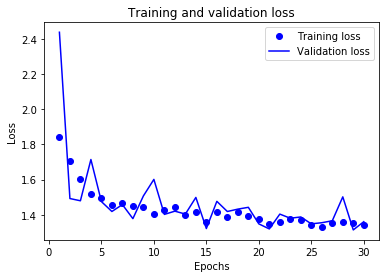

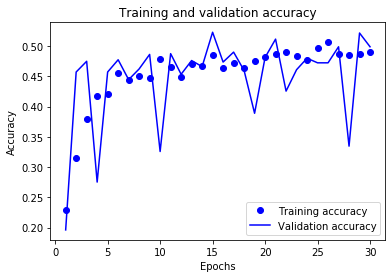

test_acc: 0.4968944127762046


In [0]:
# Now we build model 10.

from keras.applications import VGG19 # Import the VGG19 library.

backend.clear_session()
conv_base = VGG19 (weights = 'imagenet', #Useing the VGG66 CNN that was trained on ImageNet data.  
                  include_top = False, # We are using our own classification (lungs x-ray classification) and not the ImageNet multiclassification. So include top = false.
                  input_shape = (150, 150, 3))

# Here we freeze all the layers except the last 5.
for layer in conv_base.layers[:-5]:
  layer.trainable = False
for layer in conv_base.layers:
  print(layer, layer.trainable)

conv_base.summary() # Lets look at the parameters now.
weight_decay = 1e-4

modelvgg19 = models.Sequential()
modelvgg19.add(conv_base) # Add the VGG19 weights
modelvgg19.add(layers.SeparableConv2D(32, (3,3), padding = 'same', activation = 'elu', kernel_regularizer=regularizers.l2(weight_decay)))
modelvgg19.add(BatchNormalization())
modelvgg19.add(layers.Dropout(0.1))
modelvgg19.add(layers.MaxPool2D((2,2), padding = 'same'))
modelvgg19.add(layers.SeparableConv2D(64, (3,3), padding = 'same', activation = 'elu', kernel_regularizer=regularizers.l2(weight_decay)))
modelvgg19.add(layers.MaxPool2D((2,2), padding = 'same'))
modelvgg19.add(BatchNormalization())
modelvgg19.add(layers.SeparableConv2D(64, (3,3), padding = 'same', activation = 'elu', kernel_regularizer=regularizers.l2(weight_decay)))
modelvgg19.add(layers.MaxPool2D((2,2), padding = 'same'))
modelvgg19.add(BatchNormalization())
modelvgg19.add(layers.Flatten())
modelvgg19.add(layers.Dense(512, activation='elu', kernel_regularizer=regularizers.l2(weight_decay)))
modelvgg19.add(layers.Dropout(0.4))
modelvgg19.add(layers.Dense(6, activation = 'softmax'))

# We will use data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical')

validataion_generator = train_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical')

modelvgg19.compile(optimizer = optimizers.rmsprop(lr=0.0001),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'])

history = modelvgg19.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validataion_generator,
    validation_steps=40)

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(history_dict['acc']) + 1)

plt.plot(epochs, loss_values, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss_values, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, acc_values, 'bo', label = 'Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

test_loss, test_acc = modelvgg19.evaluate_generator(test_generator, steps = 25)
print('test_acc:', test_acc)

modelvgg19.save('Practicum_Nih_Pred_Lung_disease_10.h5')